In [1]:
!pip install transformers datasets tweet-preprocessor ray[tune] hyperopt

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import preprocessor as p # tweet-preprocessor
import nltk
import re
import seaborn as sns
import torch

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.special import softmax
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

In [3]:
dataset_dem = pd.read_csv('/content/drive/MyDrive/democrat_tweets_v2.csv')
dataset_gop = pd.read_csv('/content/drive/MyDrive/republican_tweets_v2.csv')

dataset_dem["label"] = "Democrat"
dataset_gop["label"] = "Republican"

dataset_final = pd.concat([dataset_dem, dataset_gop])
dataset_final.reset_index(drop=True, inplace=True)

In [4]:
LABEL_MAP = {
    "Democrat": 0,
    "Republican": 1
}

def buildLabels(row):
    return LABEL_MAP.get(row["label"])

def cleanTweet(row):
  tweet = row["text"]
  tweet = str(p.clean(tweet))
  tweet = re.sub(r'[^\w\s]', '', tweet) # punctuation
  tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet) # numbers
  return tweet

  
dataset_final["label"] = dataset_final.apply(lambda row: buildLabels(row), axis=1)
dataset_final["clean_text"] = dataset_final.apply(lambda row: cleanTweet(row), 
                                                  axis=1)

In [5]:
dataset_clf = dataset_final[["clean_text", "label"]]
dataset_clf.reset_index(drop=True, inplace=True)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                  dataset_clf.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset_clf.label.values)

dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

dataset_clf.loc[X_train, 'data_type'] = 'train'
dataset_clf.loc[X_val, 'data_type'] = 'test'

dataset_train = dataset_clf.loc[dataset_clf.data_type == 'train']
dataset_test = dataset_clf.loc[dataset_clf.data_type == 'test']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [7]:
def get_dataloaders(data, batch_size):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                            do_lower_case=True)
  # tokenize train and test data so BERT can understand it
  encoded_data_train = tokenizer.batch_encode_plus(
      data[data.data_type=='train'].clean_text.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding=True,
      max_length=64, 
      return_tensors='pt'
  )

  encoded_data_test = tokenizer.batch_encode_plus(
      data[data.data_type=='test'].clean_text.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding=True, 
      max_length=64, 
      return_tensors='pt'
  )


  # destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  labels_train = torch.tensor(data[data.data_type=='train'].label.values)

  input_ids_test = encoded_data_test['input_ids']
  attention_masks_test = encoded_data_test['attention_mask']
  labels_test = torch.tensor(data[data.data_type=='test'].label.values)

  train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

  train_dataloader = DataLoader(train_data, 
                                sampler=RandomSampler(train_data), 
                                batch_size=batch_size)

  test_dataloader = DataLoader(test_data,
                              sampler=SequentialSampler(test_data),
                              batch_size=batch_size)
  
  return train_dataloader, test_dataloader

In [8]:
def auc_score(preds, labels):
  soft_preds = softmax(preds, axis=1) # logit -> probability
  if np.shape(preds)[1] > 2: # check for multi-class
    return roc_auc_score(labels, soft_preds, multi_class='ovr')
  else:
    soft_preds = soft_preds[:,1]
    return roc_auc_score(labels, soft_preds)

def acc_score_by_class(preds, labels):
  label_dict_inverse = {v: k for k, v in LABEL_MAP.items()} 

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [9]:
def evaluate(model, dataloader, device):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []
  
  for batch in dataloader:
      
      # convert data to CUDA
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {
          'input_ids':      batch[0],
          'attention_mask': batch[1],
          'labels':         batch[2],
      }

      with torch.no_grad():        
          outputs = model(**inputs) # get predictions
          
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
  
  loss_val_avg = loss_val_total/len(dataloader) 
  
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
          
  return loss_val_avg, predictions, true_vals

In [10]:
def train_and_hyperparam_search(config,
                                model_init, # function to init a clean version of the net
                                data,       # data as Pandas array
                                cv          # rounds of cross-validation
                                ):
  losses = []
  aucs = []
  skf = StratifiedKFold(n_splits=cv, shuffle=True)
  for train_idx, test_idx in skf.split(data.clean_text, data.label):
    model = model_init()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Device: {device}")

    optimizer = AdamW(model.parameters(),
                    lr=config['lr'],
                    eps=config['eps'],
                    weight_decay=config['weight_decay'])
    
    data.loc[train_idx, 'data_type'] = 'train'
    data.loc[test_idx, 'data_type'] = 'test'
    
    train_dataloader, test_dataloader = get_dataloaders(data,
                                                        config['batch_size'])

    for epoch in range(1, config['epochs']+1):
      model.train() # enter training mode
      loss_train_total = 0

      for batch in train_dataloader:
          model.zero_grad()
          
          # get CUDA data
          batch = tuple(b.to(device) for b in batch)
          
          inputs = {
              'input_ids':      batch[0],
              'attention_mask': batch[1],
              'labels':         batch[2],
          }

          outputs = model(**inputs) # evaluate
          
          # for reference, we are using cross-entropy loss here,
          # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward() # do backprop

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
              
      
      loss_train_avg = loss_train_total/len(train_dataloader)    
      print(f"Training loss for epoch {epoch}: {loss_train_avg}")        
      
      val_loss, predictions, true_vals = evaluate(model, test_dataloader, device)
      auc = auc_score(predictions, true_vals)

      losses.append(val_loss)
      aucs.append(auc)

  tune.report(loss=np.mean(losses), auc=np.mean(aucs))

In [11]:
from functools import partial

def model_init():
   return BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                        num_labels=2,
                                                        output_attentions=False,
                                                        output_hidden_states=False)   

   
config = {
    "lr": tune.loguniform(1e-6, 2e-5),
    "eps": tune.loguniform(1e-10, 1e-7),
    "weight_decay": tune.loguniform(1e-10, 1e-5),
    "batch_size": tune.choice([4, 8, 16, 32]),
    "epochs": tune.choice([2, 3, 4, 5])
}

scheduler = ASHAScheduler(
    metric="auc",
    mode="max",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)

reporter = CLIReporter(metric_columns=["loss", "auc", "training_iteration"])
hyperopt_search = HyperOptSearch(metric="auc", mode="max")

result = tune.run(
    partial(train_and_hyperparam_search, model_init=model_init, data=dataset_clf, cv=3),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=8,
    scheduler=scheduler,
    search_alg=hyperopt_search,
    progress_reporter=reporter
)

2020-12-06 21:54:10,192	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-06 21:54:12,888	WARNING experiment.py:274 -- No name detected on trainable. Using DEFAULT.
2020-12-06 21:54:12,899	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.
2020-12-06 21:54:12,904	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-06_21-54-12
Number of trials: 1/8 (1 RUNNING)
+------------------+----------+-------+--------------+----------+-------------+-------------+----------------+
| Trial name       | status   | loc   |   batch_size |   epochs |         eps |          lr |   weight_decay |
|------------------+----------+-------+--------------+----------+-------------+-------------+----------------|
| DEFAULT_93c0b262 | RUNNING  |       |           16 |        2 | 8.74307e-08 | 3.17616e-06 |    4.44746e-06 |
+------------------+----------+-------+--------------+----------+-------------+-------------+----------------+




(pid=3570) 2020-12-06 21:54:14.418094: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3570) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3570) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3570) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=3570) Device: cuda
(pid=3570) Training loss for epoch 1: 0.6874588143945944
(pid=3570) Training loss for epoch 2: 0.6579281278330871


(pid=3570) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3570) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3570) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3570) Some weights of BertForSequenceClassification were 

(pid=3570) Device: cuda
(pid=3570) Training loss for epoch 1: 0.6831984628330577
(pid=3570) Training loss for epoch 2: 0.6295477007374619


(pid=3570) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3570) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3570) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3570) Some weights of BertForSequenceClassification were 

(pid=3570) Device: cuda
(pid=3570) Training loss for epoch 1: 0.6896376248561975
(pid=3570) Training loss for epoch 2: 0.6446749519820165
Result for DEFAULT_93c0b262:
  auc: 0.7010685096769064
  date: 2020-12-06_21-57-28
  done: false
  experiment_id: ad6ea9a1351c4a2ab5cc40fef198e6db
  experiment_tag: 1_batch_size=16,epochs=2,eps=8.7431e-08,lr=3.1762e-06,weight_decay=4.4475e-06
  hostname: 9f015b94bce8
  iterations_since_restore: 1
  loss: 0.6484827520449956
  node_ip: 172.28.0.2
  pid: 3570
  time_since_restore: 192.85943293571472
  time_this_iter_s: 192.85943293571472
  time_total_s: 192.85943293571472
  timestamp: 1607291848
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 93c0b262
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7010685096769064
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_t

(pid=3569) 2020-12-06 21:57:30.453258: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3569) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3569) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3569) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=3569) Device: cuda
(pid=3569) Training loss for epoch 1: 0.6438384826737221
(pid=3569) Training loss for epoch 2: 0.5253591016687528


(pid=3569) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3569) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3569) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3569) Some weights of BertForSequenceClassification were 

(pid=3569) Device: cuda
(pid=3569) Training loss for epoch 1: 0.6576527116274593
(pid=3569) Training loss for epoch 2: 0.5459362753111907


(pid=3569) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3569) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3569) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3569) Some weights of BertForSequenceClassification were 

(pid=3569) Device: cuda
(pid=3569) Training loss for epoch 1: 0.6473018204925036
(pid=3569) Training loss for epoch 2: 0.5150285905057733
Result for DEFAULT_93da3836:
  auc: 0.7741223182935467
  date: 2020-12-06_22-00-42
  done: false
  experiment_id: aebdd516a5094872a2e3b23a816dfcc2
  experiment_tag: 2_batch_size=16,epochs=2,eps=4.9409e-09,lr=1.192e-05,weight_decay=5.4279e-09
  hostname: 9f015b94bce8
  iterations_since_restore: 1
  loss: 0.5876687847077846
  node_ip: 172.28.0.2
  pid: 3569
  time_since_restore: 190.6906440258026
  time_this_iter_s: 190.6906440258026
  time_total_s: 190.6906440258026
  timestamp: 1607292042
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 93da3836
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7375954139852265
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:

(pid=3743) 2020-12-06 22:00:44.686630: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3743) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3743) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3743) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=3743) Device: cuda
(pid=3743) Training loss for epoch 1: 0.6737338277426633
(pid=3743) Training loss for epoch 2: 0.5817461814543213
(pid=3743) Training loss for epoch 3: 0.48520403784332855
(pid=3743) Training loss for epoch 4: 0.38269224025384346


(pid=3743) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3743) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3743) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3743) Some weights of BertForSequenceClassification were 

(pid=3743) Device: cuda
(pid=3743) Training loss for epoch 1: 0.6687278533824766
(pid=3743) Training loss for epoch 2: 0.5731373658083906
(pid=3743) Training loss for epoch 3: 0.46451878423492116
(pid=3743) Training loss for epoch 4: 0.3626871705243383


(pid=3743) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3743) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3743) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3743) Some weights of BertForSequenceClassification were 

(pid=3743) Device: cuda
(pid=3743) Training loss for epoch 1: 0.656917680243049
(pid=3743) Training loss for epoch 2: 0.5591062987693632
(pid=3743) Training loss for epoch 3: 0.4638087544025797
(pid=3743) Training loss for epoch 4: 0.3583991745806704
Result for DEFAULT_08916c9e:
  auc: 0.7654883861405105
  date: 2020-12-06_22-07-41
  done: false
  experiment_id: fd51929a8de444c5a115b72b9bc0908c
  experiment_tag: 3_batch_size=8,epochs=4,eps=5.3614e-10,lr=5.1235e-06,weight_decay=5.95e-10
  hostname: 9f015b94bce8
  iterations_since_restore: 1
  loss: 0.6080678408739693
  node_ip: 172.28.0.2
  pid: 3743
  time_since_restore: 415.7941617965698
  time_this_iter_s: 415.7941617965698
  time_total_s: 415.7941617965698
  timestamp: 1607292461
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 08916c9e
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.76548838614

(pid=3867) 2020-12-06 22:07:43.962826: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3867) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3867) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3867) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=3867) Device: cuda
(pid=3867) Training loss for epoch 1: 0.6659432315465176
(pid=3867) Training loss for epoch 2: 0.5698366764217916


(pid=3867) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3867) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3867) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3867) Some weights of BertForSequenceClassification were 

(pid=3867) Device: cuda
(pid=3867) Training loss for epoch 1: 0.6621177912962557
(pid=3867) Training loss for epoch 2: 0.565703477447081


(pid=3867) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3867) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3867) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3867) Some weights of BertForSequenceClassification were 

(pid=3867) Device: cuda
(pid=3867) Training loss for epoch 1: 0.6615715485931647
(pid=3867) Training loss for epoch 2: 0.5648742151079755
Result for DEFAULT_7c146234:
  auc: 0.7477215538761834
  date: 2020-12-06_22-11-24
  done: true
  experiment_id: 53aa6825d6654ecf94dfcece7311fd2e
  experiment_tag: 4_batch_size=8,epochs=2,eps=1.3204e-10,lr=5.3132e-06,weight_decay=4.3124e-06
  hostname: 9f015b94bce8
  iterations_since_restore: 1
  loss: 0.6089330666544862
  node_ip: 172.28.0.2
  pid: 3867
  time_since_restore: 218.8997461795807
  time_this_iter_s: 218.8997461795807
  time_total_s: 218.8997461795807
  timestamp: 1607292684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7c146234
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.756604970008347
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4

(pid=3921) 2020-12-06 22:11:26.394202: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3921) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3921) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3921) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=3921) Device: cuda
(pid=3921) Training loss for epoch 1: 0.6956076835743105
(pid=3921) Training loss for epoch 2: 0.6605298362597071
(pid=3921) Training loss for epoch 3: 0.6178350409474036
(pid=3921) Training loss for epoch 4: 0.5851631229272997


(pid=3921) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3921) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3921) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3921) Some weights of BertForSequenceClassification were 

(pid=3921) Device: cuda
(pid=3921) Training loss for epoch 1: 0.6890913410620256
(pid=3921) Training loss for epoch 2: 0.660669498672389
(pid=3921) Training loss for epoch 3: 0.621974135589118
(pid=3921) Training loss for epoch 4: 0.5803396920814659


(pid=3921) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3921) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3921) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3921) Some weights of BertForSequenceClassification were 

(pid=3921) Device: cuda
(pid=3921) Training loss for epoch 1: 0.6844221293324172
(pid=3921) Training loss for epoch 2: 0.6635838739498697
(pid=3921) Training loss for epoch 3: 0.6358960293459169
(pid=3921) Training loss for epoch 4: 0.5976972739503841
Result for DEFAULT_75ffc31a:
  auc: 0.7022200578489209
  date: 2020-12-06_22-18-23
  done: true
  experiment_id: 97a654b2bb3a4e73a04a62b0e8268c08
  experiment_tag: 5_batch_size=8,epochs=4,eps=2.0165e-09,lr=1.6044e-06,weight_decay=7.5865e-06
  hostname: 9f015b94bce8
  iterations_since_restore: 1
  loss: 0.6349883893573726
  node_ip: 172.28.0.2
  pid: 3921
  time_since_restore: 415.687890291214
  time_this_iter_s: 415.687890291214
  time_total_s: 415.687890291214
  timestamp: 1607293103
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 75ffc31a
  
== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.747721553876

2020-12-06 22:18:23,833	WARNING worker.py:1091 -- A worker died or was killed while executing task ffffffffffffffffbd5c534001000000.
(pid=4025) 2020-12-06 22:18:25.446829: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=4025) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4025) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4025) - This IS NOT exp

(pid=4025) Device: cuda
(pid=4025) Training loss for epoch 1: 0.6485756629645222
(pid=4025) Training loss for epoch 2: 0.5144355733587285
(pid=4025) Training loss for epoch 3: 0.3113925965747448
(pid=4025) Training loss for epoch 4: 0.17163462344218383


(pid=4025) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4025) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4025) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=4025) Some weights of BertForSequenceClassification were 

(pid=4025) Device: cuda
(pid=4025) Training loss for epoch 1: 0.6528240102108078
(pid=4025) Training loss for epoch 2: 0.4820829935447134
(pid=4025) Training loss for epoch 3: 0.30347999192849556
(pid=4025) Training loss for epoch 4: 0.18855236008800944


(pid=4025) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4025) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4025) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=4025) Some weights of BertForSequenceClassification were 

(pid=4025) Device: cuda
(pid=4025) Training loss for epoch 1: 0.6301101142107838
(pid=4025) Training loss for epoch 2: 0.4564822460665847
(pid=4025) Training loss for epoch 3: 0.2799960495998161
(pid=4025) Training loss for epoch 4: 0.14648363495603053
Result for DEFAULT_fa8d65ec:
  auc: 0.802226355350435
  date: 2020-12-06_22-24-31
  done: false
  experiment_id: 312a340260434186837e7dca9f53da29
  experiment_tag: 6_batch_size=16,epochs=4,eps=4.5852e-08,lr=1.7238e-05,weight_decay=3.6007e-10
  hostname: 9f015b94bce8
  iterations_since_restore: 1
  loss: 0.6847203586654117
  node_ip: 172.28.0.2
  pid: 4025
  time_since_restore: 364.18568444252014
  time_this_iter_s: 364.18568444252014
  time_total_s: 364.18568444252014
  timestamp: 1607293471
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fa8d65ec
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7566

(pid=4124) 2020-12-06 22:24:33.082891: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=4124) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4124) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4124) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=4124) Device: cuda
(pid=4124) Training loss for epoch 1: 0.6813772070407867
(pid=4124) Training loss for epoch 2: 0.608902422785759
(pid=4124) Training loss for epoch 3: 0.5276772546768188


(pid=4124) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4124) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4124) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=4124) Some weights of BertForSequenceClassification were 

(pid=4124) Device: cuda
(pid=4124) Training loss for epoch 1: 0.6769887971878051
(pid=4124) Training loss for epoch 2: 0.604877507686615
(pid=4124) Training loss for epoch 3: 0.5174921447038651


(pid=4124) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4124) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4124) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=4124) Some weights of BertForSequenceClassification were 

(pid=4124) Device: cuda
(pid=4124) Training loss for epoch 1: 0.6816722357273102
(pid=4124) Training loss for epoch 2: 0.6142327558994293
(pid=4124) Training loss for epoch 3: 0.5606629383563996
Result for DEFAULT_f4728628:
  auc: 0.7416295701844141
  date: 2020-12-06_22-28-47
  done: true
  experiment_id: dd3bcda399b042508878af9e4450814b
  experiment_tag: 7_batch_size=32,epochs=3,eps=3.8195e-09,lr=7.6325e-06,weight_decay=6.9155e-10
  hostname: 9f015b94bce8
  iterations_since_restore: 1
  loss: 0.6120096676879458
  node_ip: 172.28.0.2
  pid: 4124
  time_since_restore: 253.45842099189758
  time_this_iter_s: 253.45842099189758
  time_total_s: 253.45842099189758
  timestamp: 1607293727
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f4728628
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7477215538761834
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/

(pid=4212) 2020-12-06 22:28:49.994873: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=4212) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4212) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4212) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=4212) Device: cuda
(pid=4212) Training loss for epoch 1: 0.6913504522256176
(pid=4212) Training loss for epoch 2: 0.6731835784334125
(pid=4212) Training loss for epoch 3: 0.6443099596283652
(pid=4212) Training loss for epoch 4: 0.6112600787721499
(pid=4212) Training loss for epoch 5: 0.570579975542396


(pid=4212) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4212) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4212) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=4212) Some weights of BertForSequenceClassification were 

(pid=4212) Device: cuda
(pid=4212) Training loss for epoch 1: 0.6993850547857959
(pid=4212) Training loss for epoch 2: 0.665694347535721
(pid=4212) Training loss for epoch 3: 0.6268568529625131
(pid=4212) Training loss for epoch 4: 0.5848219186970682
(pid=4212) Training loss for epoch 5: 0.5407810208171305


(pid=4212) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=4212) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=4212) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=4212) Some weights of BertForSequenceClassification were 

(pid=4212) Device: cuda
(pid=4212) Training loss for epoch 1: 0.6979626694110909
(pid=4212) Training loss for epoch 2: 0.6601872949889211
(pid=4212) Training loss for epoch 3: 0.624181820888712
(pid=4212) Training loss for epoch 4: 0.5859001474549071
(pid=4212) Training loss for epoch 5: 0.5461449701376636


2020-12-06 22:36:19,868	INFO tune.py:439 -- Total run time: 2530.49 seconds (2526.88 seconds for the tuning loop).


Result for DEFAULT_cf7ac8f2:
  auc: 0.7061946681364962
  date: 2020-12-06_22-36-19
  done: true
  experiment_id: 5db98ba69dcc4d82999d1a756965da29
  experiment_tag: 8_batch_size=16,epochs=5,eps=1.6768e-08,lr=2.0771e-06,weight_decay=1.9284e-10
  hostname: 9f015b94bce8
  iterations_since_restore: 1
  loss: 0.6304776781400043
  node_ip: 172.28.0.2
  pid: 4212
  time_since_restore: 448.3074371814728
  time_this_iter_s: 448.3074371814728
  time_total_s: 448.3074371814728
  timestamp: 1607294179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: cf7ac8f2
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7446755620302987
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-06_21-54-12
Number of trials: 8/8 (8 TERMINATED)
+------------------+------------+---

Text(0, 0.5, 'Score')

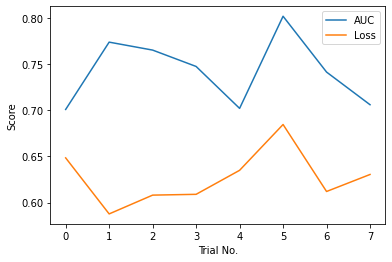

In [52]:
dfs = result.fetch_trial_dataframes()

aucs = []
losses = []
for d in dfs.values():
  aucs.append(d.auc)
  losses.append(d.loss)

plt.plot(range(0, 8), aucs, label="AUC")
plt.plot(range(0, 8), losses, label="Loss")
plt.legend()
plt.xlabel("Trial No.")
plt.ylabel("Score")


best candidates appear to come from trials 1 & 5.
let's evaluate both

In [63]:
def train(model, epochs, train_dataloader, test_dataloader, optimizer, scheduler):
  for epoch in tqdm(range(1, epochs+1)): # use tqdm for a progress bar
    model.train() # enter training mode
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        
        # get CUDA data
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }

        outputs = model(**inputs) # evaluate
        
        # for reference, we are using cross-entropy loss here,
        # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # do backprop

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model, test_dataloader, device)
    auc = auc_score(predictions, true_vals)
    tqdm.write(f'Testing loss: {val_loss}')
    tqdm.write(f'AUC: {auc}')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                  dataset_clf.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset_clf.label.values)

dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

dataset_clf.loc[X_train, 'data_type'] = 'train'
dataset_clf.loc[X_val, 'data_type'] = 'test'

dataset_train = dataset_clf.loc[dataset_clf.data_type == 'train']
dataset_test = dataset_clf.loc[dataset_clf.data_type == 'test']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [71]:
# model 1
# |  batch_size |   epochs |         eps |          lr |   weight_decay |
# |           16 |        2 | 4.94087e-09 | 1.19201e-05|    5.42786e-09 |

encoded_data_train = tokenizer.batch_encode_plus(
    dataset_clf[dataset_clf.data_type=='train'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=64, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    dataset_clf[dataset_clf.data_type=='test'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=64, 
    return_tensors='pt'
)


# destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset_clf[dataset_clf.data_type=='train'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(dataset_clf[dataset_clf.data_type=='test'].label.values)

train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

train_dataloader = DataLoader(train_data, 
                              sampler=RandomSampler(train_data), 
                              batch_size=16)

test_dataloader = DataLoader(test_data,
                            sampler=SequentialSampler(test_data),
                            batch_size=16)


In [72]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for i in range(3): # get an average over 3 trains
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

  optimizer = AdamW(model.parameters(),
                    lr=1.19201e-05,
                    eps=4.94087e-09,
                    weight_decay=5.42786e-09)
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0, 
                                              num_training_steps=len(train_dataloader)*2)
  model.to(device)

  train(model, 2, train_dataloader, test_dataloader, optimizer, scheduler)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.6361791188754733
Testing loss: 0.5764645791572073
AUC: 0.7883244206773619



Epoch 2
Training loss: 0.5321358040211692
Testing loss: 0.5607826968897944
AUC: 0.8115609880315763



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.6388184028485465
Testing loss: 0.6122633879599364
AUC: 0.7365991851285969



Epoch 2
Training loss: 0.5277750305240116
Testing loss: 0.6109791786774345
AUC: 0.7583078686019864



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.6526552048467454
Testing loss: 0.6084092764750771
AUC: 0.7447478991596638



Epoch 2
Training loss: 0.5465535365399861
Testing loss: 0.5799120094465173
AUC: 0.7819264069264069



In [81]:
print(f"Avg. final test loss: {(0.5764645791572073 + 0.6109791786774345 + 0.5799120094465173)/3.0}")
print(f"Avg. final AUC: {(0.8115609880315763 + 0.7583078686019864 + 0.7819264069264069)/3.0}")

Avg. final test loss: 0.5891185890937197
Avg. final AUC: 0.7839317545199899


Accuracy: 0.7408450704225352


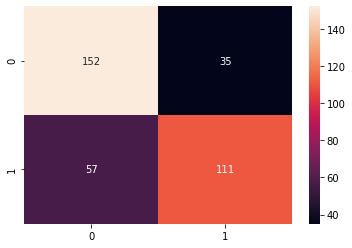

In [80]:
_, preds, true_vals = evaluate(model, test_dataloader, device)
print(f"Accuracy: {accuracy_score(true_vals, np.argmax(preds, axis=1))}")
sns.heatmap(confusion_matrix(true_vals, np.argmax(preds, axis=1)), annot=True, fmt="d")

In [66]:
# model 2
# |  batch_size |   epochs |         eps |          lr |   weight_decay |
# |           16|        4 | 4.58521e-08 | 1.72375e-05 |    3.60069e-10 |

encoded_data_train = tokenizer.batch_encode_plus(
    dataset_clf[dataset_clf.data_type=='train'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=64, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    dataset_clf[dataset_clf.data_type=='test'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=64, 
    return_tensors='pt'
)


# destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset_clf[dataset_clf.data_type=='train'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(dataset_clf[dataset_clf.data_type=='test'].label.values)

train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

train_dataloader = DataLoader(train_data, 
                              sampler=RandomSampler(train_data), 
                              batch_size=16)

test_dataloader = DataLoader(test_data,
                            sampler=SequentialSampler(test_data),
                            batch_size=16)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr=1.72375e-05,
                  eps=4.58521e-08,
                  weight_decay=3.60069e-10)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_dataloader)*4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [67]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train(model, 4, train_dataloader, test_dataloader, optimizer, scheduler)


Epoch 1
Training loss: 0.6486814102483174
Testing loss: 0.6048837498478268
AUC: 0.7663292589763179



Epoch 2
Training loss: 0.5203371852163284
Testing loss: 0.5443878847619762
AUC: 0.8169085816144639



Epoch 3
Training loss: 0.4046687007186905
Testing loss: 0.5714977824169657
AUC: 0.8080277565571683



Epoch 4
Training loss: 0.29489860376195304
Testing loss: 0.598727541125339
AUC: 0.8163992869875222



Looks like this model starts overfitting after epoch 2 (testing loss increases in future epochs). However, we get our best AUC and loss after 2 epochs with these parameters. Let's stop it there but keep everything else the same.

In [82]:
for _ in range(3):
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=2,
                                                        output_attentions=False,
                                                        output_hidden_states=False)
  model.to(device)

  optimizer = AdamW(model.parameters(),
                    lr=1.72375e-05,
                    eps=4.58521e-08,
                    weight_decay=3.60069e-10)
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0, 
                                              num_training_steps=len(train_dataloader)*2)

  train(model, 2, train_dataloader, test_dataloader, optimizer, scheduler)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.6286163980525638
Testing loss: 0.5749250028444373
AUC: 0.7927170868347339



Epoch 2
Training loss: 0.4954110320125307
Testing loss: 0.5581308383008708
AUC: 0.8104469060351414



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.6502253110446627
Testing loss: 0.5786595344543457
AUC: 0.7859689330277564



Epoch 2
Training loss: 0.508418273358118
Testing loss: 0.5645494979360829
AUC: 0.8090463458110517



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.6561132683640435
Testing loss: 0.5989941501099131
AUC: 0.7695123503947034



Epoch 2
Training loss: 0.5268681375753312
Testing loss: 0.5688818576543228
AUC: 0.7943086325439267



In [83]:
print(f"Avg. final test loss: {(0.5581308383008708 + 0.5645494979360829 + 0.5688818576543228)/3.0}")
print(f"Avg. final AUC: {(0.8104469060351414 + 0.8090463458110517 + 0.7943086325439267)/3.0}")

Avg. final test loss: 0.5638540646304255
Avg. final AUC: 0.8046006281300399


Accuracy: 0.7380281690140845


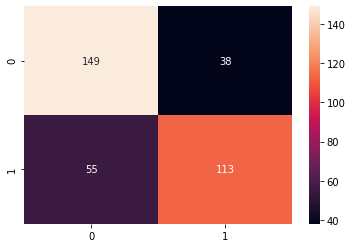

In [84]:
_, preds, true_vals = evaluate(model, test_dataloader, device)
print(f"Accuracy: {accuracy_score(true_vals, np.argmax(preds, axis=1))}")
sns.heatmap(confusion_matrix(true_vals, np.argmax(preds, axis=1)), annot=True, fmt="d")

Model 2 performs better on average. Lets pick that one.